In [1]:
from bpd.io import load_dataset, load_dataset_jax
import matplotlib.pyplot as plt 
import numpy as np 
import jax.numpy as jnp
import jax 
from jax.scipy import stats

from jax import random, jit, vmap

from functools import partial

In [2]:
fpath = "/pscratch/sd/i/imendoza/data/cache_chains/exp73_45/shear_samples_452_plus.npz"

In [3]:
ds = load_dataset(fpath)

In [4]:
keys = list(ds['samples'].keys())[2:]
keys

['a_logflux',
 'mean_logflux',
 'mean_loghlr',
 'sigma_e',
 'sigma_logflux',
 'sigma_loghlr']

In [5]:
# get mean and covariance across all parameters 
x = [ds['samples'][k] for k in keys]
x = np.stack(x, axis=-1)
x.shape

(3000, 6)

In [6]:
mu = np.mean(x, axis=0)
cov = np.cov(x, rowvar=False)
mu.shape, cov.shape

((6,), (6, 6))

In [7]:
np.sqrt(cov[0,0]), ds['samples']['a_logflux'].std()

(np.float64(0.4399500740318108), np.float64(0.4398767429080359))

In [8]:
mu = jnp.array(mu)
cov = jnp.array(cov)
mu.shape, cov.shape

((6,), (6, 6))

In [9]:
from bpd.prior import true_all_params_skew_logprior, interim_gprops_logprior
from jax import Array
from jax.scipy.stats import multivariate_normal
from bpd.likelihood import shear_loglikelihood
from bpd.utils import uniform_logpdf

def logtarget_post_as_prior(
    params,
    *,
    data: dict[str, Array],
    sigma_e_int: float,
    mu:Array,
    cov: Array
):
    g = params["g"]
    sigma_e = params["sigma_e"]
    mean_logflux = params["mean_logflux"]
    sigma_logflux = params["sigma_logflux"]
    mean_loghlr = params["mean_loghlr"]
    sigma_loghlr = params["sigma_loghlr"]
    a_logflux = params["a_logflux"]

    # ignores dx,dy
    _logprior = partial(
        true_all_params_skew_logprior,
        sigma_e=sigma_e,
        mean_logflux=mean_logflux,
        sigma_logflux=sigma_logflux,
        a_logflux=a_logflux,
        mean_loghlr=mean_loghlr,
        sigma_loghlr=sigma_loghlr,
    )
    _interim_logprior = partial(
        interim_gprops_logprior,
        sigma_e=sigma_e_int,
        free_flux_hlr=True,
        free_dxdy=False,
    )
    loglike = shear_loglikelihood(
        g, post_params=data, logprior=_logprior, interim_logprior=_interim_logprior
    )
    g_mag = jnp.sqrt(g[0] ** 2 + g[1] ** 2)
    logprior_g = uniform_logpdf(g_mag, 0.0, 1.0) + jnp.log(1 / (2 * jnp.pi))

    # use posterior
    x = jnp.array([a_logflux, mean_logflux, mean_loghlr, sigma_e, sigma_logflux, sigma_loghlr]) # match order of keys above
    logprior_alpha = multivariate_normal.logpdf(x, mean=mu, cov=cov)
    
    return logprior_g + logprior_alpha + loglike


## Now we run with this new logtarget

In [10]:
fpath_samples = "/pscratch/sd/i/imendoza/data/cache_chains/exp72_45/interim_samples_451_plus.npz"

In [11]:
ds_plus = load_dataset_jax(fpath_samples)

In [12]:
samples_plus = ds_plus["samples"]
ppp = {
    "lf": samples_plus["lf"],
    "lhlr": samples_plus["lhlr"],
    "e1": samples_plus["e1"],
    "e2": samples_plus["e2"],
}


In [14]:
g1 = ds_plus["hyper"]["g1"]
g2 = ds_plus["hyper"]["g2"]
true_g = jnp.array([g1, g2])
sigma_e = ds_plus["hyper"]["shape_noise"]
sigma_e_int = ds_plus["hyper"]["sigma_e_int"]
mean_logflux = ds_plus["hyper"]["mean_logflux"]
sigma_logflux = ds_plus["hyper"]["sigma_logflux"]
a_logflux = ds_plus["hyper"]["a_logflux"]
mean_loghlr = ds_plus["hyper"]["mean_loghlr"]
sigma_loghlr = ds_plus["hyper"]["sigma_loghlr"]

In [15]:
rng_key = random.key(42)
k1, k2 = random.split(rng_key)
_logtarget = jit(partial(logtarget_post_as_prior, sigma_e_int=sigma_e_int, mu=mu, cov=cov))

In [16]:
# Reshape samples
n_splits = 500
split_size = ppp["e1"].shape[0] // n_splits
assert split_size * n_splits == ppp["e1"].shape[0], "dimensions do not match"
ppp = {k: jnp.reshape(v, (n_splits, split_size, 300)) for k, v in ppp.items()}

In [17]:
ppp['e1'].shape

(500, 120, 300)

In [18]:
from bpd.pipelines import init_all_params

k1s = random.split(k1, n_splits)
true_params = {
    "sigma_e": sigma_e,
    "mean_logflux": mean_logflux,
    "sigma_logflux": sigma_logflux,
    "a_logflux": a_logflux,
    "mean_loghlr": mean_loghlr,
    "sigma_loghlr": sigma_loghlr,
}
_init_fnc = partial(
    init_all_params,
    true_params=true_params,
    p=0.1,
)

In [19]:
init_positions = vmap(_init_fnc)(k1s)
init_positions["g"] = jnp.zeros((n_splits, 2))
init_positions['a_logflux'].shape

(500,)

In [20]:
from bpd.chains import run_inference_nuts

pipe = jit(
    partial(
        run_inference_nuts,
        logtarget=_logtarget,
        n_samples=1000,
        initial_step_size=0.01,
        max_num_doublings=7,
        n_warmup_steps=1000,
    )
)

In [21]:
k2s = random.split(k2, n_splits)


In [22]:
# jit function quickly
print("JITting function...")
_ = pipe(
    k2,
    data={k: v[0] for k, v in ppp.items()},
    init_positions={k: v[0] for k, v in init_positions.items()},
)

JITting function...


## One example

In [33]:
# lt's check on one example no? 
one_samples = pipe(
    k2s[3],
    data={k: v[3] for k, v in ppp.items()},
    init_positions={k: v[3] for k, v in init_positions.items()},
)

In [34]:
one_samples.keys()

dict_keys(['a_logflux', 'g', 'mean_logflux', 'mean_loghlr', 'sigma_e', 'sigma_logflux', 'sigma_loghlr'])

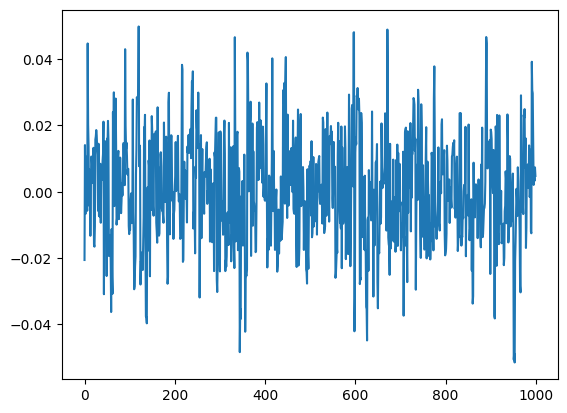

In [35]:
plt.plot(one_samples['g'][:, 0])

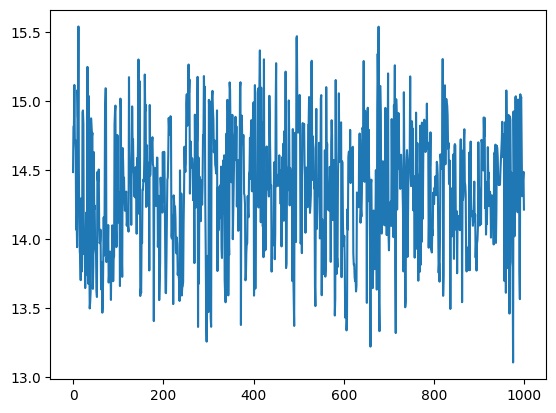

In [36]:
plt.plot(one_samples['a_logflux'])

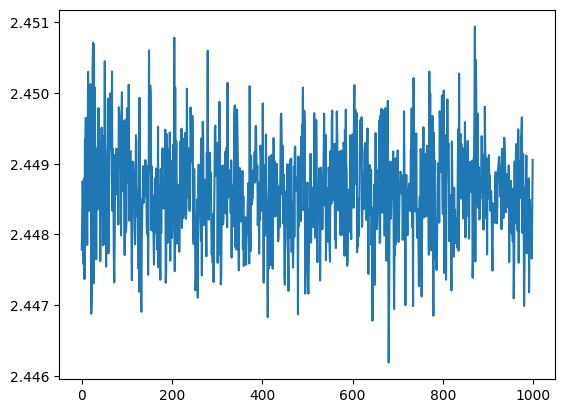

In [37]:
plt.plot(one_samples['mean_logflux'])

In [ ]:
plt.plot(one_samples['mean_logflux'])

## All samples

In [ ]:
samples_plus = vmap(pipe)(k2s, ppp, init_positions)